In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('soc-sign-bitcoinotc.csv.gz', compression='gzip', header=None)

data.columns = ['source', 'target', 'rating', 'time']
#convert timestamp to datetime format
data["time"] = pd.to_datetime(data["time"], unit='s')

#Check for null values
print(data.isna().any().any())

# Display the first few rows of the dataset
print(data.head())
data.describe()



False
   source  target  rating                          time
0       6       2       4 2010-11-08 18:45:11.728359936
1       6       5       2 2010-11-08 18:45:41.533780224
2       1      15       1 2010-11-08 19:05:40.390490112
3       4       3       7 2010-11-08 19:41:17.369750016
4      13      16       8 2010-11-08 22:10:54.447459840


,source,target,rating,time
count,35592.000000,35592.000000,35592.000000,35592
mean,2353.847269,2417.478254,1.012025,2012-12-17 02:23:47.466307328
min,1.000000,1.000000,-10.000000,2010-11-08 18:45:11.728359936
25%,988.000000,978.000000,1.000000,2012-03-08 21:47:10.083377408
50%,2125.000000,2178.000000,1.000000,2013-01-17 01:06:14.492320
75%,3722.000000,3804.000000,2.000000,2013-08-15 20:29:16.842030080
max,6000.000000,6005.000000,10.000000,2016-01-25 01:12:03.757280
std,1605.771178,1658.232170,3.562094,NaN


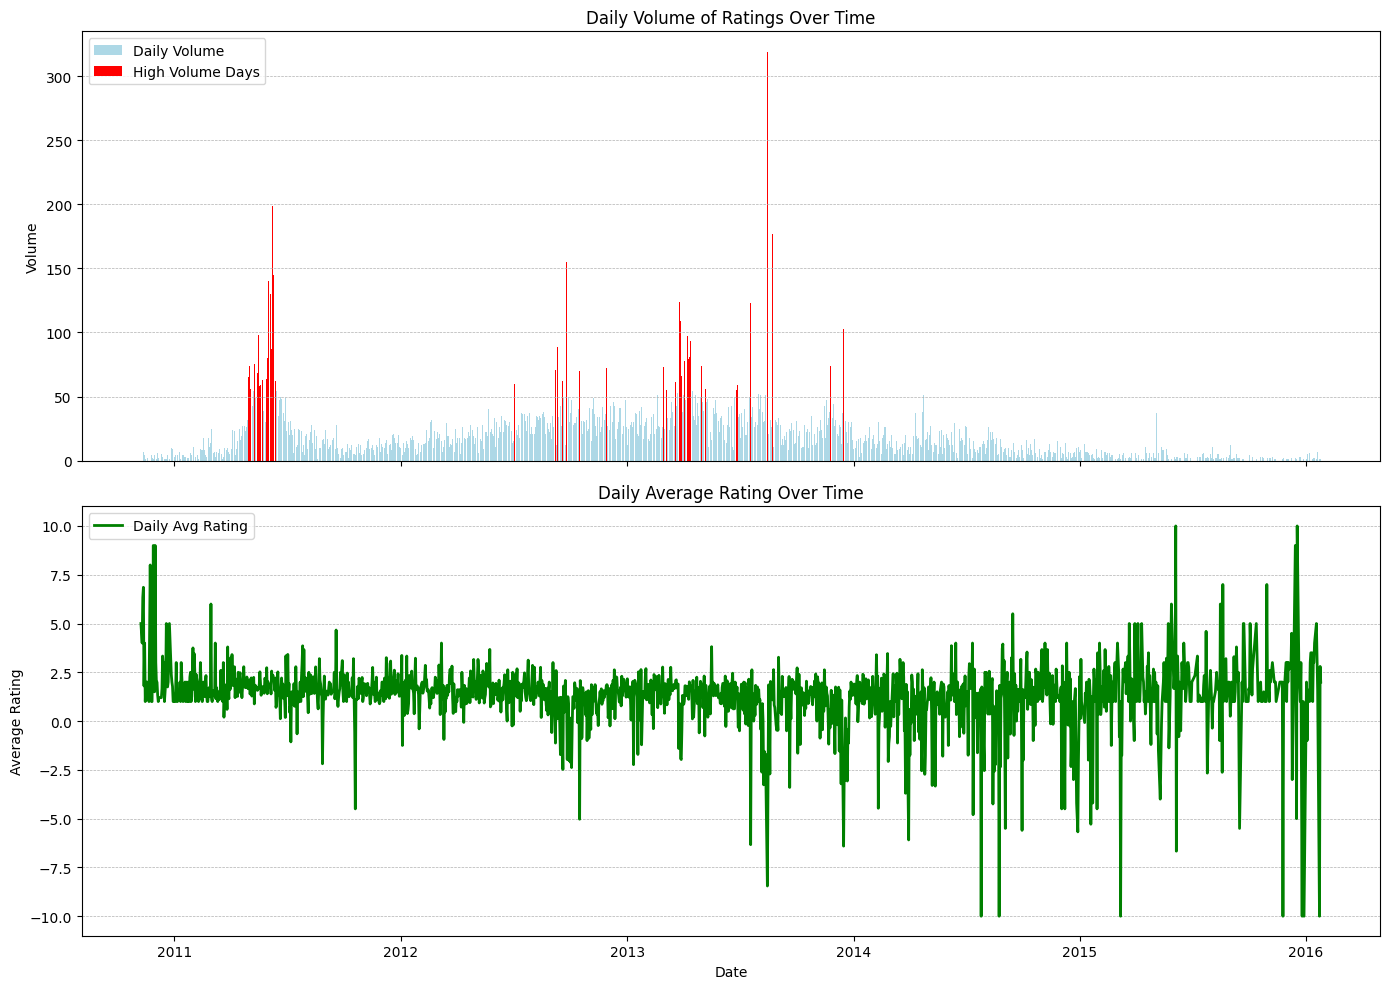

In [4]:
# Are there anomalies or unusual patterns 
data['datetime'] = pd.to_datetime(data['time'], unit='s')
# Calculate the daily volume of ratings
daily_volume = data.groupby(data['datetime'].dt.date).size()

# Calculate the daily average rating
daily_avg_rating = data.groupby(data['datetime'].dt.date)['rating'].mean()

# Calculate a threshold for high volume days (e.g., 95th percentile)
high_volume_threshold = daily_volume.quantile(0.95)

# Identify days with exceptionally high volumes
high_volume_days = daily_volume[daily_volume > high_volume_threshold]

# Plot the daily volume of ratings
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot daily volume of ratings on the first axis
ax1.bar(daily_volume.index, daily_volume.values, color='lightblue', label='Daily Volume')
ax1.bar(high_volume_days.index, high_volume_days.values, color='red', label='High Volume Days')
ax1.set_ylabel('Volume')
ax1.legend(loc='upper left')
ax1.set_title('Daily Volume of Ratings Over Time')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

# Plot daily average rating on the second axis
ax2.plot(daily_avg_rating.index, daily_avg_rating.values, color='green', label='Daily Avg Rating', linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Rating')
ax2.legend(loc='upper left')
ax2.set_title('Daily Average Rating Over Time')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')

plt.tight_layout()
plt.show()

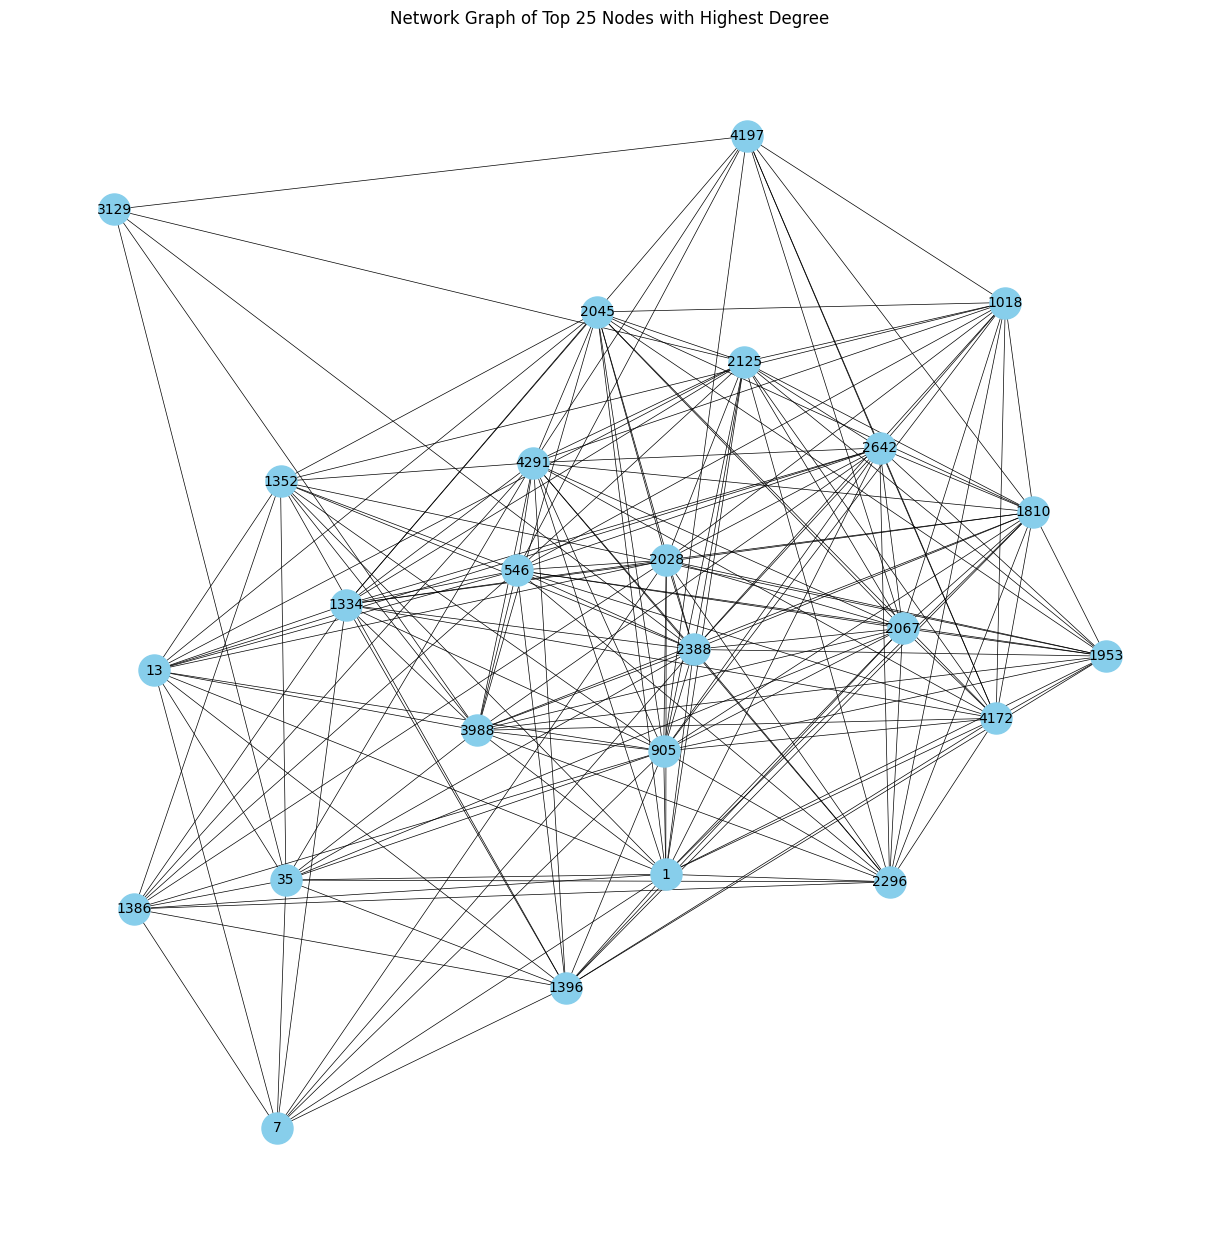

In [5]:

# Create a graph from the data
G = nx.from_pandas_edgelist(data, 'source', 'target', ['rating'])

# Determine the top 50 nodes with the highest degree
top_nodes = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:25]
top_node_ids = [node[0] for node in top_nodes]

# Filter the graph to include only the top nodes
subgraph = G.subgraph(top_node_ids)

# Generate the network graph for the top 50 degree nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph)  # Positioning of nodes
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, width=0.5)
plt.title('Network Graph of Top 25 Nodes with Highest Degree')
plt.show()


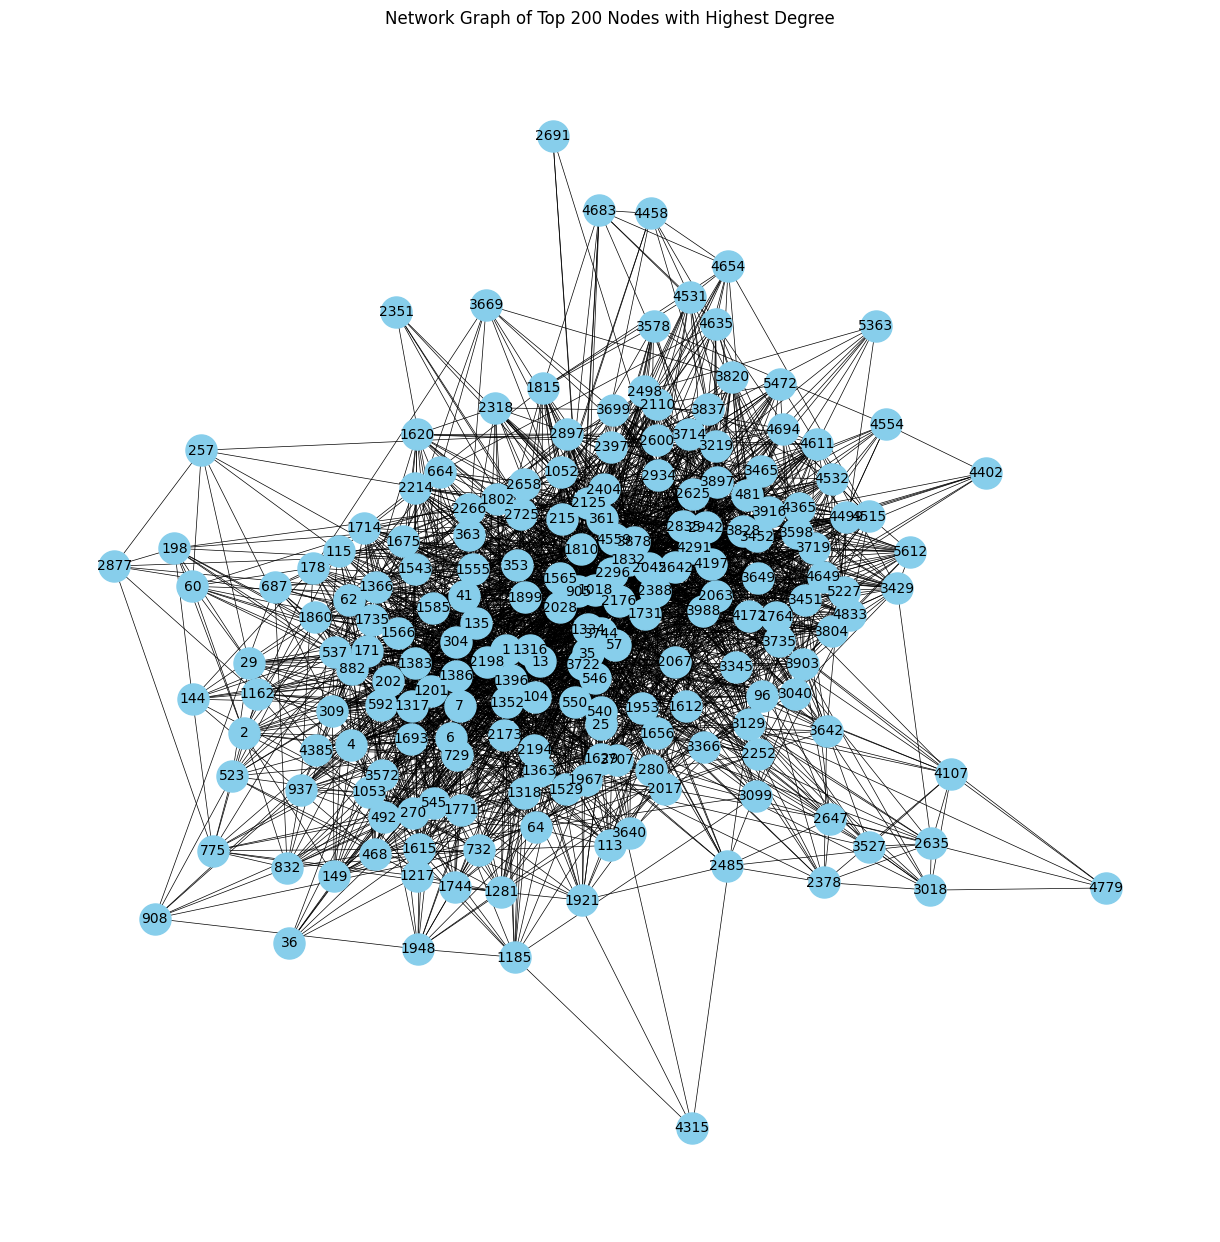

In [6]:
# Determine the top 50 nodes with the highest degree
top_nodes = sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:200]
top_node_ids = [node[0] for node in top_nodes]

# Filter the graph to include only the top nodes
subgraph = G.subgraph(top_node_ids)

# Generate the network graph for the top 50 degree nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(subgraph)  # Positioning of nodes
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, width=0.5)
plt.title('Network Graph of Top 200 Nodes with Highest Degree')
plt.show()

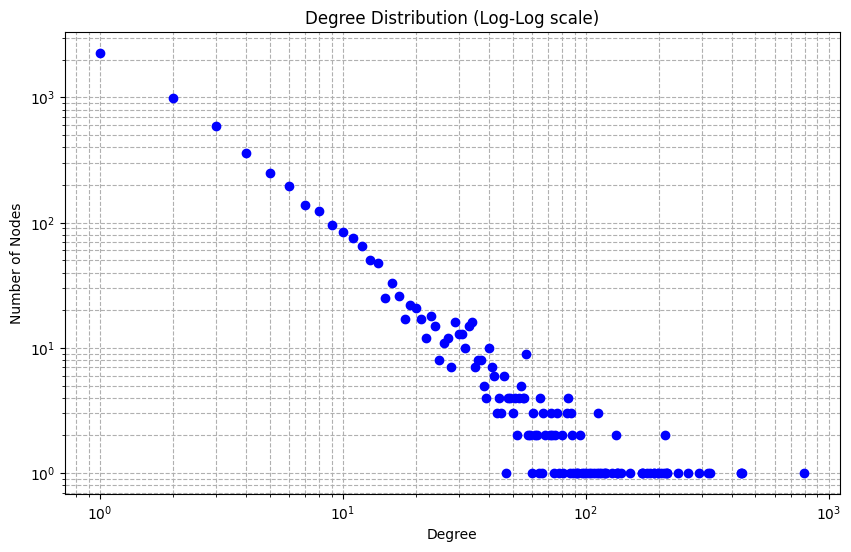

In [7]:
# Compute the degree distribution 
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = {}
for d in degree_sequence:
    if d not in degree_count:
        degree_count[d] = 0
    degree_count[d] += 1

degrees = list(degree_count.keys())
count = list(degree_count.values())

# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees, count, 'bo')
plt.title("Degree Distribution (Log-Log scale)")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()

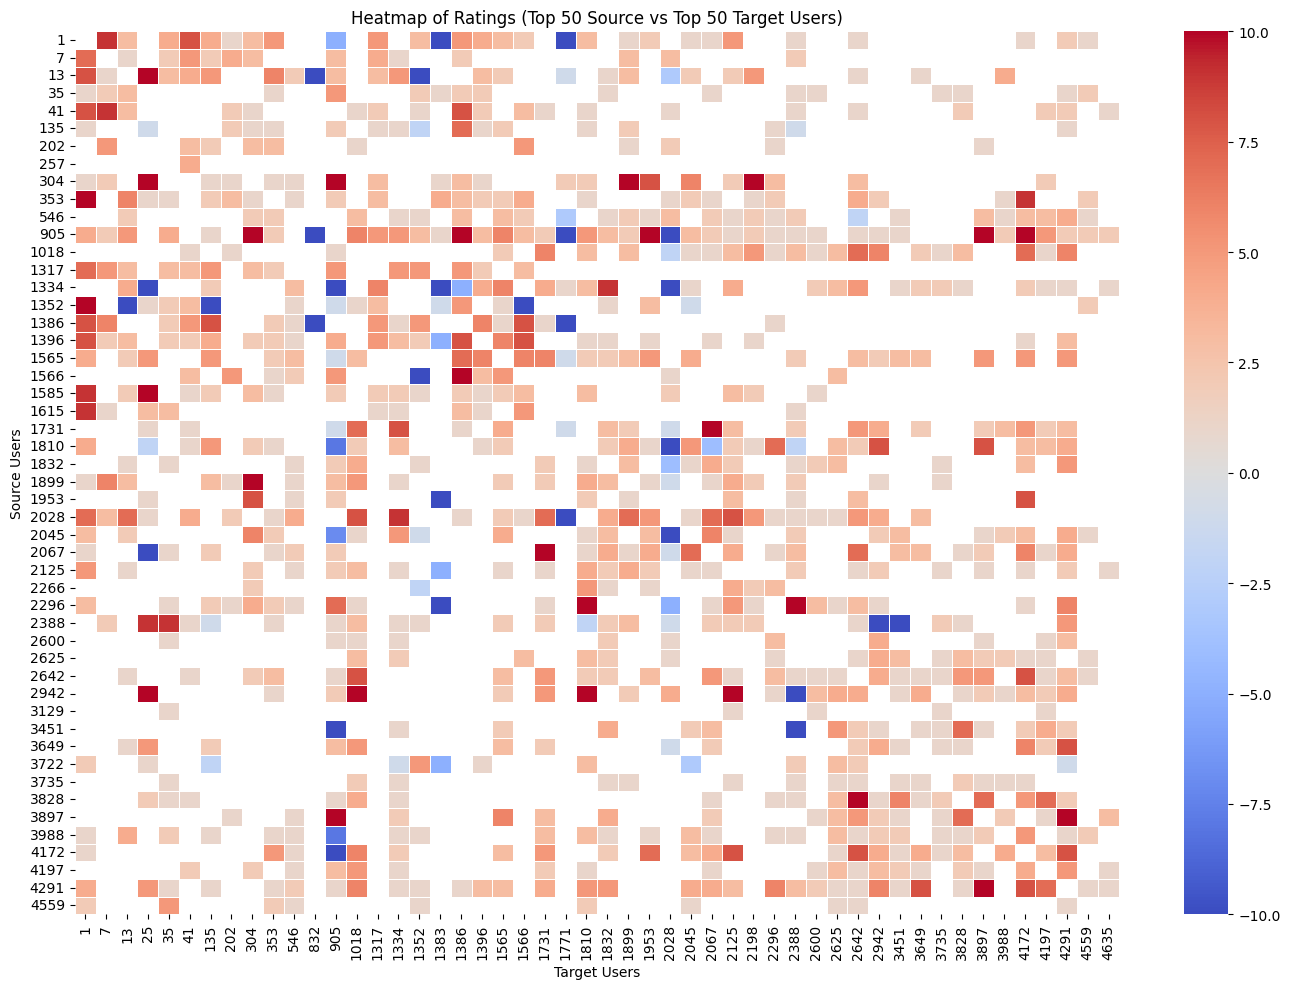

In [8]:
top_sources = data['source'].value_counts().head(50).index
top_targets = data['target'].value_counts().head(50).index

# Filtering data for these users
filtered_data = data[data['source'].isin(top_sources) & data['target'].isin(top_targets)]

# Creating a pivot table for the heatmap
heatmap_data = filtered_data.pivot_table(index='source', columns='target', values='rating', aggfunc='mean')

#  Heatmap of ratings
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Heatmap of Ratings (Top 50 Source vs Top 50 Target Users)')
plt.xlabel('Target Users')
plt.ylabel('Source Users')
plt.tight_layout()
plt.show()

/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


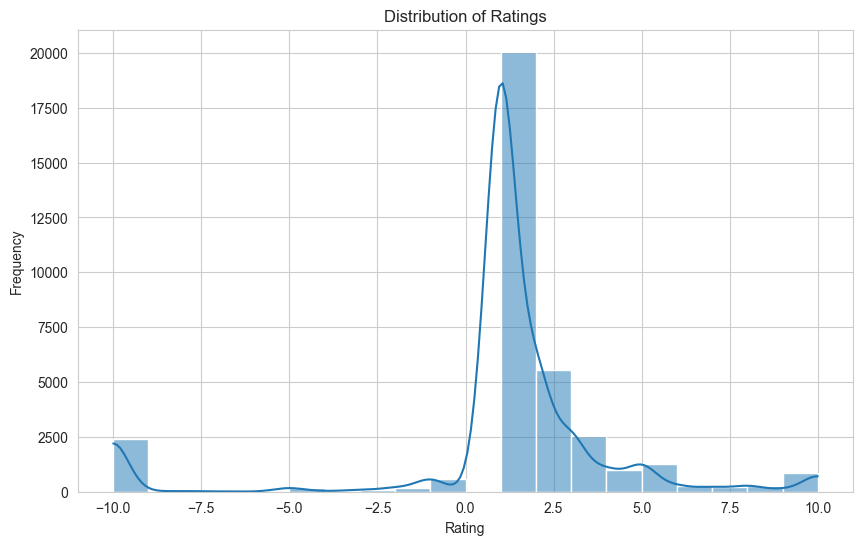

In [9]:

# Setting the style
sns.set_style("whitegrid")

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='rating', kde=True, bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

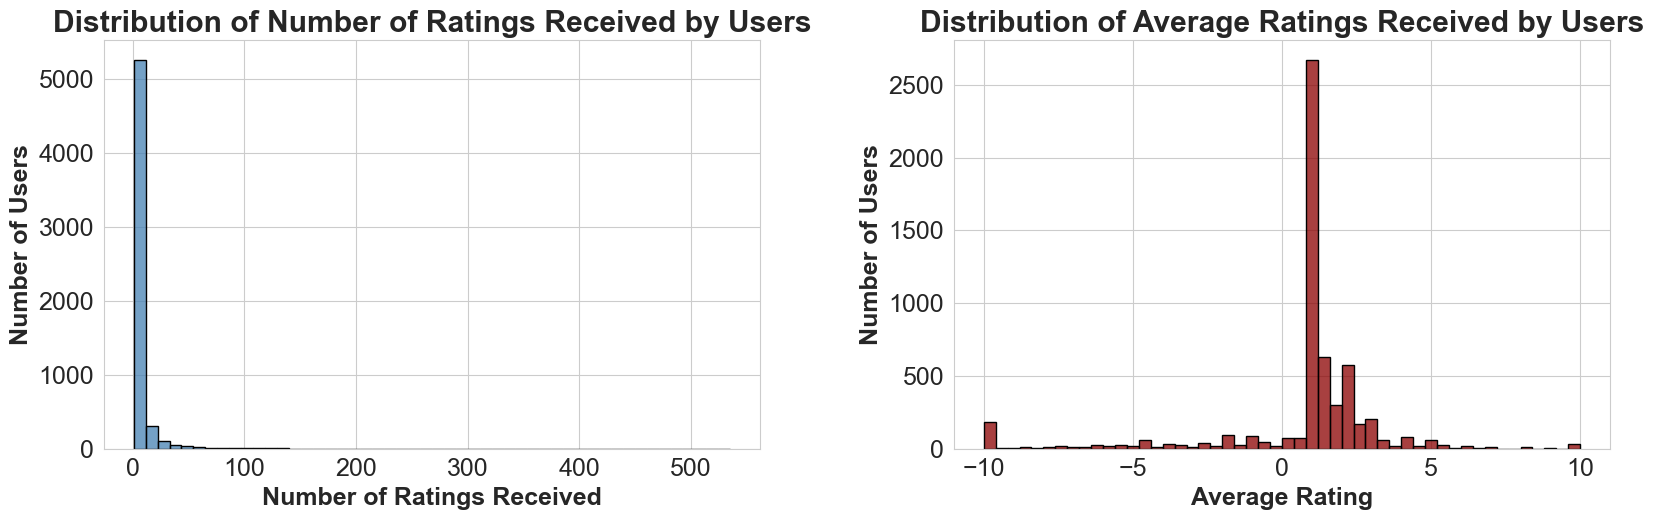

In [10]:
#Are there hubs of trust in the network

# Count the number of ratings each user (target) has received
rating_counts = data.groupby('target').size()

# Calculate the average rating for each user
average_ratings = data.groupby('target')['rating'].mean()

# Set the aesthetic style, font scale, and other properties 
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Plot a smoothed distribution of the number of ratings
sns.histplot(rating_counts, bins=50, color='steelblue', ax=ax[0], kde=False, edgecolor="k", linewidth=1)
ax[0].set_title('Distribution of Number of Ratings Received by Users')
ax[0].set_xlabel('Number of Ratings Received')
ax[0].set_ylabel('Number of Users')

# Plot a smoothed distribution of the average ratings 
sns.histplot(average_ratings, bins=50, color='darkred', ax=ax[1], kde=False, edgecolor="k", linewidth=1)
ax[1].set_title('Distribution of Average Ratings Received by Users')
ax[1].set_xlabel('Average Rating')
ax[1].set_ylabel('Number of Users')

plt.tight_layout(pad=4.0)
plt.show()


/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gwendolyn/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


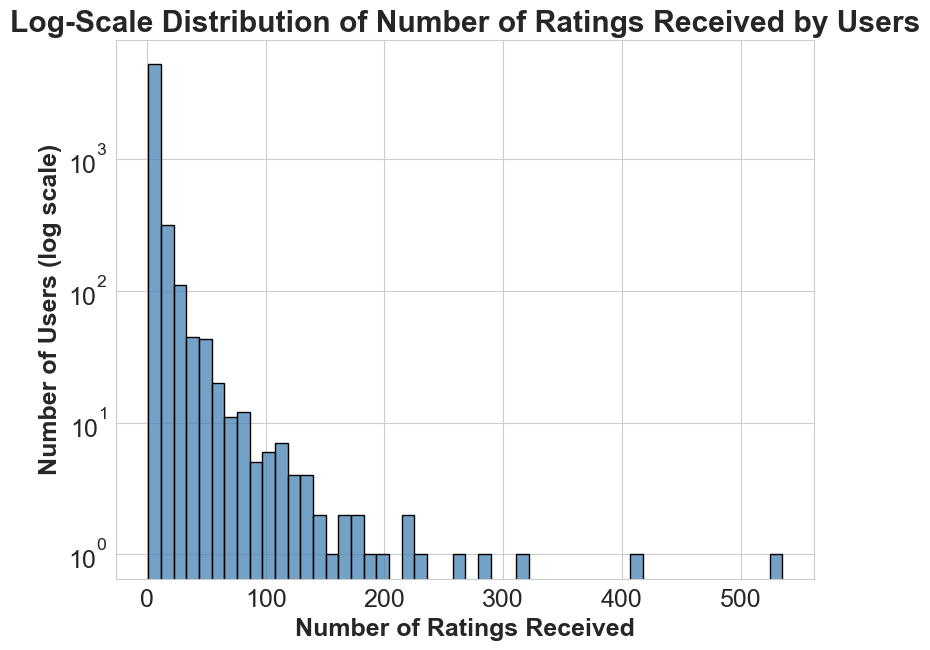

In [11]:

# Count the number of ratings each user (target) has received
rating_counts = data.groupby('target').size()

# Set the aesthetic style, font scale, and other properties 
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(9, 7))  # Adjusted to have only one plot

# Now with a logarithmic y-scale to see users with 100+ ratings more clearly
sns.histplot(rating_counts, bins=50, color='steelblue', ax=ax, kde=False, edgecolor="k", linewidth=1)
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale
ax.set_title('Log-Scale Distribution of Number of Ratings Received by Users')
ax.set_xlabel('Number of Ratings Received')
ax.set_ylabel('Number of Users (log scale)')

plt.show()



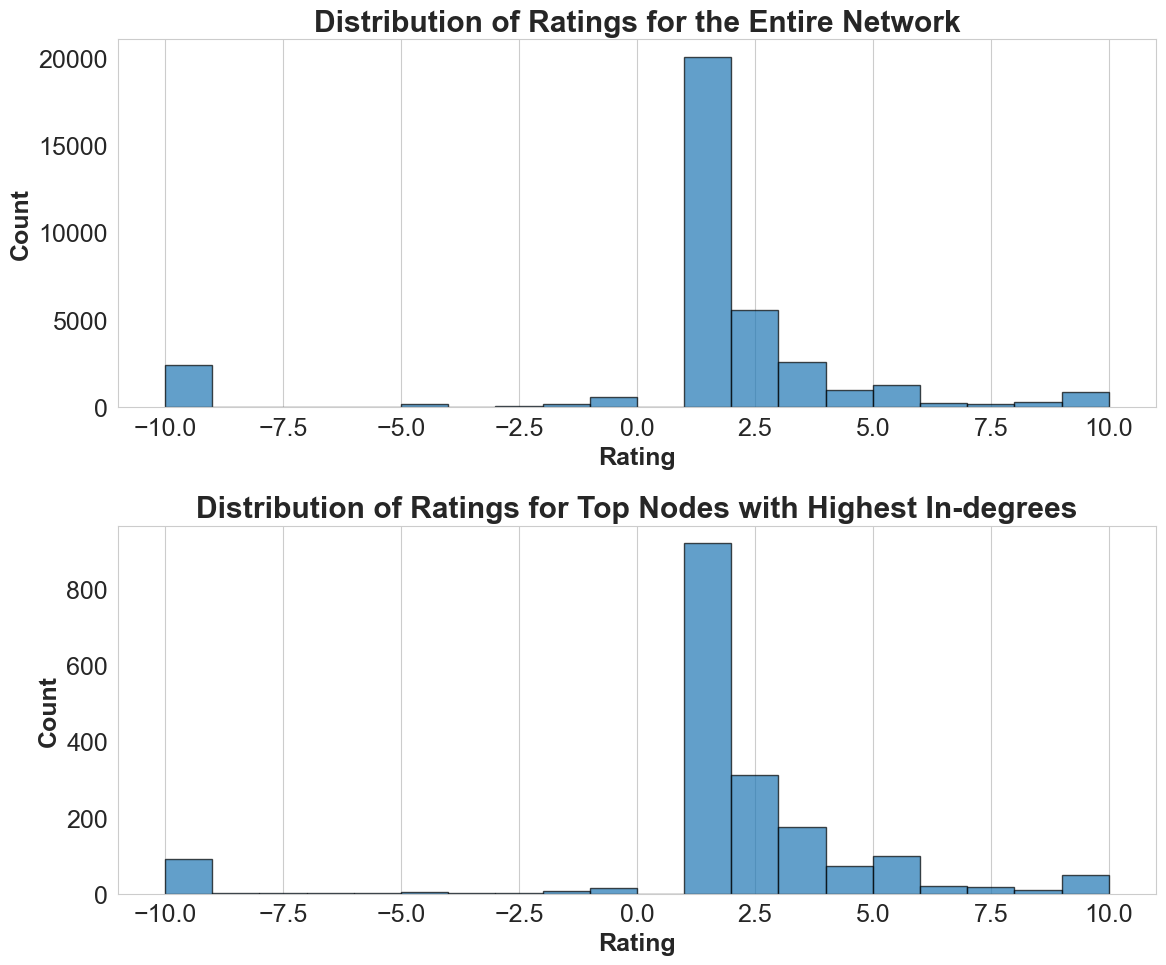

In [12]:

# Calculate in-degrees and out-degrees
in_degrees = data.groupby('target').size()
out_degrees = data.groupby('source').size()

# Create a DataFrame for degrees
degrees_df = pd.DataFrame({
    'in_degree': in_degrees,
    'out_degree': out_degrees
}).fillna(0)

# Display the top nodes with the highest in-degrees
top_in_degrees = degrees_df.sort_values(by='in_degree', ascending=False).head()

# Extract ratings for the top nodes with the highest in-degrees
top_nodes_ratings = data[data['target'].isin(top_in_degrees.index)]['rating']

# Plot the distribution of ratings for the entire network and for the top nodes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Distribution for the entire network
data['rating'].hist(ax=axes[0], bins=range(-10, 11), edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Ratings for the Entire Network')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')

# Distribution for the top nodes
top_nodes_ratings.hist(ax=axes[1], bins=range(-10, 11), edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Ratings for Top Nodes with Highest In-degrees')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()


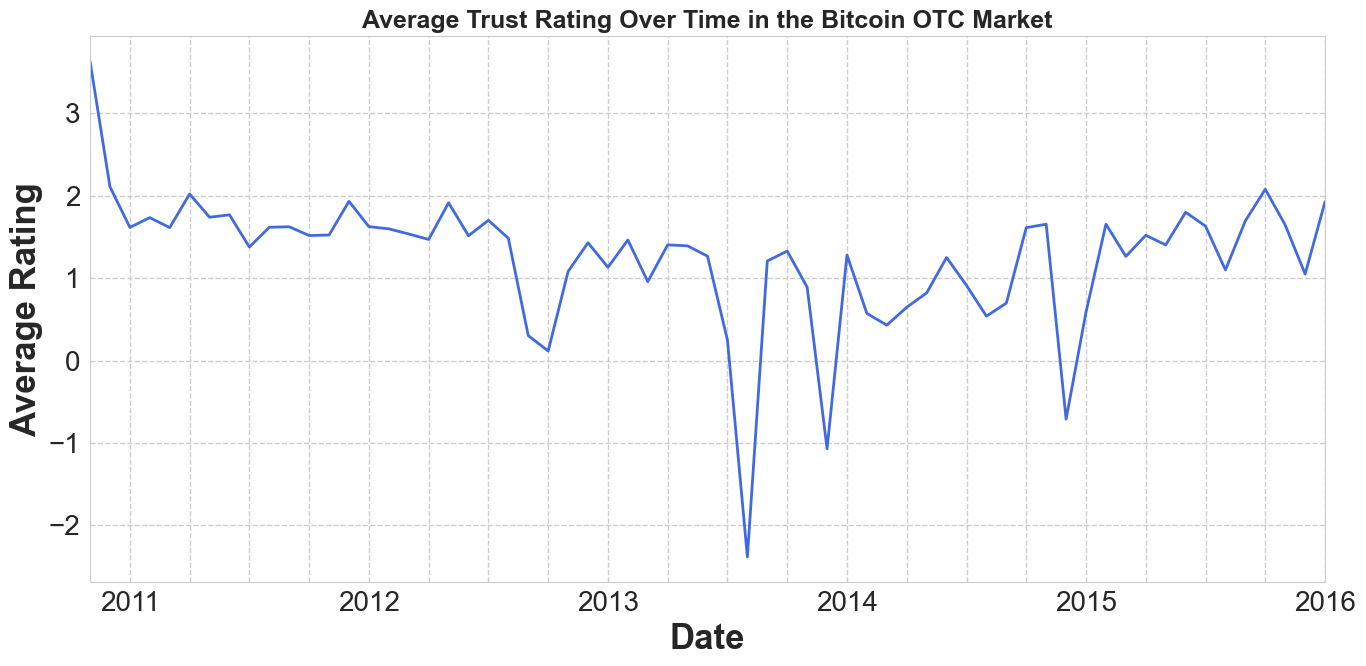

In [13]:
#How does trust evolve over time
# Convert 'time' from UNIX time to datetime format
data['date'] = pd.to_datetime(data['time'], unit='s')

# Group by date and calculate the average rating
avg_rating_over_time = data.groupby(data['date'].dt.to_period('M'))['rating'].mean()

# Convert the time period back to datetime for plotting
avg_rating_over_time.index = avg_rating_over_time.index.to_timestamp()


# Plot the average trust rating over time 
plt.figure(figsize=(14, 7))
avg_rating_over_time.plot(linewidth=2, color='royalblue')
plt.title('Average Trust Rating Over Time in the Bitcoin OTC Market', fontsize=18)
plt.xlabel('Date', fontsize=25)
plt.ylabel('Average Rating', fontsize=25)
plt.grid(True, which='both', linestyle='--', linewidth=1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# Show the plot
plt.show()
